# Penndulum Model Codes

## Dependencies

In [129]:
import os
import shutil
import random; random.seed(42)

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
from torch import nn
from reservoirpy import mat_gen, ESN

## Directories:

In [130]:
# training data
train_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/train'
train_dir_video = '/raid/cs152/zxaa2018/penndulum//train_and_test_split/dpc_dataset_traintest_4_200_h264/train'

# test data
test_inputs_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/test_inputs/'
test_targets_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/test_targets/'
test_targets_video = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_h264/test_targets/'

# validation data
validation_inputs_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/validation_inputs/'
validation_targets_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/validation_targets/'
validation_targets_video = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_h264/validation_targets/'

## Functions and Class Definitions

### Data Transformation Functions

In [131]:
# some constants
DEFAULT_X_RED, DEFAULT_Y_RED = (240, 232)

PIXEL_DISTANCE_GREEN_TO_RED = 118 # approx. value | calculated with the Pythagorean theorem and averaged: np.sqrt((y_green-y_red)**2 + (x_green-x_red)**2)
PIXEL_DISTANCE_BLUE_TO_GREEN = 90 # approx. value | calculated with the Pythagorean theorem and averaged: np.sqrt((y_blue-y_green)**2 + (x_blue-x_green)**2)

def raw_to_pixel(l):
    '''Convert the raw coordinates to pixel coordinates.'''
    assert isinstance(l, list)
    return [x/5 for x in l]


def pixel_to_raw(l):
    '''Convert the pixel coordinates to raw coordinates.'''
    assert isinstance(l, list)
    return [x*5 for x in l]


def raw_cartesian_to_polar_angles(l):
    '''Convert the cartesian coordinates to polar coordinates.'''
    assert isinstance(l, list)
    x_red, y_red, x_green, y_green, x_blue, y_blue = raw_to_pixel(l)

    angle_green_red = np.arctan((y_green-y_red)/(x_green-x_red+0.001))
    angle_blue_green = np.arctan((y_blue-y_green)/(x_blue-x_green+0.001))
    
    return [np.sin(angle_green_red), np.cos(angle_green_red), np.sin(angle_blue_green), np.cos(angle_blue_green)]

def polar_angles_to_raw_cartesian(l):
    '''Convert the polar coordinates back to cartesian coordinates.'''
    assert isinstance(l, list)
    sin_angle_green_red, cos_angle_green_red, sin_angle_blue_green, cos_angle_blue_green = l
    
    y_green = PIXEL_DISTANCE_GREEN_TO_RED * sin_angle_green_red + DEFAULT_Y_RED
    x_green = PIXEL_DISTANCE_GREEN_TO_RED * cos_angle_green_red + DEFAULT_X_RED

    y_blue = PIXEL_DISTANCE_BLUE_TO_GREEN * sin_angle_blue_green + y_green
    x_blue = PIXEL_DISTANCE_BLUE_TO_GREEN * cos_angle_blue_green + x_green
    
    return pixel_to_raw([DEFAULT_X_RED, DEFAULT_Y_RED, x_green, y_green, x_blue, y_blue])

### Data reading functions

Parsing training data:
training data x-y matching is like this:
x: a list of 4 frames
y: the frame that follows

In [132]:
def parse_csv_esn(csv_file):
    '''Given a csv file and a length of sequence, return the sequence in list of list'''
    X_data = []
    f = pd.read_csv(csv_file, header=None, delim_whitespace=True, engine='python')
    temp = []
    for i, row in f.iterrows():
        next_frame = row.to_list()
        X_data.append(next_frame.copy())
        
    return X_data

In [133]:
def get_seq_list(source_dir):
    result = []
    name = []
    for filename in tqdm([x for x in os.listdir(source_dir) if not x.startswith('.')]):
        # load in a file
        name.append(filename)
        X_data = parse_csv_esn(os.path.join(source_dir, filename))
        result.append(X_data)
    return result, name

In [134]:
def normalize_sequence(sequence: np.ndarray):
    '''Given a sequence in shape (n,6), normalize the sequence to [-1,1]'''
    # get range of x coords 0,2,4
    x_factor = (sequence[:,[0,2,4]].max() - sequence[:,[0,2,4]].min()) * 0.5
    y_factor = (sequence[:,[1,3,5]].max() - sequence[:,[1,3,5]].min()) * 0.5

    sequence[:,[0,2,4]] = sequence[:,[0,2,4]] / max(x_factor,1e-6) - 0.5
    sequence[:,[1,3,5]] = sequence[:,[1,3,5]] / max(y_factor, 1e-6) - 0.5

    return sequence, (x_factor, y_factor)

def denormalize_sequence(sequence: np.array, factors: tuple):
    '''Given a sequence in shape (n,6), normalized to [-1,1], and the normalize factors along the x, y axis, return the denormalized sequence'''
    sequence[:,[0,2,4]] = (sequence[:,[0,2,4]] + 0.5) * factors[0]
    sequence[:,[1,3,5]] = (sequence[:,[1,3,5]] + 0.5) * factors[1]

    return sequence
    

In [135]:
def normalize_sequence_by_pivot(sequence: np.ndarray):
    '''Given a sequence in shape (n,6), normalize the sequence to [-1,1]'''
    # get range of coords of first  axis
    a_factor = (sequence[:,[0,1]].max() - sequence[:,[0,1]].min()) * 0.5
    b_factor = (sequence[:,[2,3]].max() - sequence[:,[2,3]].min()) * 0.5
    c_factor = (sequence[:,[4,5]].max() - sequence[:,[4,5]].min()) * 0.5

    a_shift = sequence[:,[0,1]].min()
    b_shift = sequence[:,[2,3]].min()
    c_shift = sequence[:,[4,5]].min()

    sequence[:,[0,1]] = (sequence[:,[0,1]] - a_shift) / max(a_factor,1e-6) - 1
    sequence[:,[2,3]] = (sequence[:,[2,3]] - b_shift) / max(b_factor,1e-6) - 1
    sequence[:,[4,5]] = (sequence[:,[4,5]] - c_shift) / max(c_factor,1e-6) - 1

    sequence[:,[1,3,5]] = sequence[:,[1,3,5]] * -1.0

    return sequence, (a_factor, b_factor, c_factor, a_shift, b_shift, c_shift)

def denormalize_sequence_by_pivot(sequence: np.array, factors: tuple):
    '''Given a sequence in shape (n,6), normalized to [-1,1], and the normalize factors along the x, y axis, return the denormalized sequence'''
    sequence[:,[1,3,5]] = sequence[:,[1,3,5]] * -1.0
    sequence[:,[0,1]] = (sequence[:,[0,1]] + 1) * factors[0] + factors[3]
    sequence[:,[2,3]] = (sequence[:,[0,1]] + 1) * factors[1] + factors[4]
    sequence[:,[4,5]] = (sequence[:,[0,1]] + 1) * factors[2] + factors[5]

    return sequence

### Dataset Definition

In [136]:
class NormalizedDatast():
    def __init__(self,X_list: list, name_list: list):
        self.sample_List = []
        self.factor_list = []
        self.name_dict = {}
        for i, (seq, name) in enumerate(zip(X_list, name_list)):
            self.name_dict[i] = name
            norm_seq, factors = normalize_sequence_by_pivot(np.array(seq, dtype=float))
            self.sample_List.append(norm_seq)
            self.factor_list.append(factors)

    def __len__(self):
        return len(self.sample_list)
    
    def getFactor(self, index: int):
        return self.x_factor_list[index], self.y_factor_list[index]

### Model Definition

Data Visualization Functions

In [147]:
def plot_comparison_with_warmup(Xgen, Xgen_test, warm_up, length, axis1, axis2):
    t = np.arange(length)
    fig = plt.figure(figsize = (13,5))
    
    plt.gca().invert_yaxis()
    plt.subplot((121))
    plt.title(f"Ground Truth, first {length} frame")
    plt_x = [y[1] for y in Xgen_test[:,[axis1, axis2][:length]]]
    plt_y = [y[0] for y in Xgen_test[:,[axis1, axis2][:length]]]
    warm_x = [y[1] for y in warm_up[:,[axis1, axis2]]]
    warm_y = [y[0] for y in warm_up[:,[axis1, axis2]]]

    plt.plot(warm_x, warm_y, lw=1,color="lightgrey", zorder=0)
    plt.scatter(warm_x, warm_y,lw=0.5, c = 'red', s=2)
    plt.plot(plt_x, plt_y, lw=1,color="lightgrey", zorder=0)
    plt.scatter(plt_x, plt_y,lw=0.5, c = t[:len(plt_x)],cmap="viridis", s=2)
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")

    plt.subplot((122))
    plt.title(f"Prediction, first {length} frame")
    plt_x_res = [y[1] for y in Xgen[:,[axis1, axis2]][:length]]
    plt_y_res = [y[0] for y in Xgen[:,[axis1, axis2]][:length]]

    plt.plot(warm_x, warm_y, lw=1,color="lightgrey", zorder=0)
    plt.scatter(warm_x, warm_y,lw=0.5, c = 'red', s=2)
    plt.plot(plt_x_res, plt_y_res, lw=1,color="lightgrey", zorder=0)
    plt.scatter(plt_x_res, plt_y_res,lw=0.5, c = t[:len(plt_x)],cmap="viridis", s=2)
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")

In [145]:
def plot_sequence(seq, a1, a2):

    length = seq.shape[0]
    t = np.arange(length)
    
    plt.title(f"Timeserie - {length} timesteps")

    plt.plot(seq[:,a2], seq[:,a1], color="lightgray", zorder=0)
    plt.scatter(seq[:,a2], seq[:,a1], c=t[:length], cmap="viridis", s=1, zorder=1)

    plt.xlabel("$x$")
    plt.ylabel("$y$")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$t$', rotation=270)

    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

## Training, testing and analysis Codes

### Loading Training Data

In [139]:
Seq_train_p, Seq_train_name_p = get_seq_list(train_dir)
dataset_p = NormalizedDatast(Seq_train_p, Seq_train_name_p)

100%|██████████| 40/40 [00:28<00:00,  1.41it/s]


### Hyperparameter and Model instantiate

In [140]:
class ESNModel():
    def __init__(self, units, dim, input_scaling, input_connectivity, input_bias, seed, spectral_radius, density, leak_rate, regularization):
        self.units = units
        self.dim = dim
        self.input_scaling = input_scaling
        self.input_connectivity = input_connectivity
        self.input_bias = input_bias
        self.seed = seed
        self.spectral_radius = spectral_radius
        self.density = density
        self.leak_rate = leak_rate
        self.regularization = regularization
        
        self.Win = mat_gen.generate_input_weights(self.units, self.dim,    input_scaling=self.input_scaling, proba=self.input_connectivity, input_bias=self.input_bias,seed=self.seed)
        self. W = mat_gen.generate_internal_weights(self.units, sr=self.spectral_radius, proba=self.density, seed=self.seed)
        self.reservior = ESN(self.leak_rate, self.W, self.Win, ridge = self.regularization)

    def train_on_sequence(self, dataset: NormalizedDatast, index = 0, train_length = 400, forecast = 100):
        '''
        Given an index of of a sequence in the dataset (default to 0), train the reservoir on that sequence.
        '''
        seq = dataset.sample_List[index]
        states = self.reservior.train(seq[:train_length], seq[forecast: forecast + train_length])
        return states

    def generate_on_sequence(self, dataset: NormalizedDatast, index = 0, warm_up_length = 100, nb_generations = 200, start = 0):
        '''Given a sequence of a dataset, generate on that sequence'''
        test_X = dataset.sample_List[index]
        warming_inputs = test_X[start: start + warm_up_length]
        Xgen_test = test_X[start + warm_up_length : start + nb_generations + warm_up_length]
        Xgen, states, warming_out, warming_states = self.reservior.generate(nb_generations, warming_inputs=warming_inputs)
        return Xgen, Xgen_test, warming_inputs, states, warming_out, warming_states

    def reset(self):
        '''reset the model'''
        self.Win = mat_gen.generate_input_weights(self.units, self.dim,    input_scaling=self.input_scaling, proba=self.input_connectivity, input_bias=self.input_bias,seed=self.seed)
        self. W = mat_gen.generate_internal_weights(self.units, sr=self.spectral_radius, proba=self.density, seed=self.seed)
        self.reservior = ESN(self.leak_rate, self.W, self.Win, ridge = self.regularization)



In [141]:
units = 500
leak_rate = 0.2
spectral_radius = 1.0
input_scaling = 1.0
density = 0.1
input_connectivity = 1.0
regularization = 1e-6
seed = 1234

## Comparing effect of different forecast length on performance.

Using forecast length of 25, 50, 100, 200, 400. Train on the first 3000 frames 0th sequence of the train dataset, warmup of 2800:3000 of the same sequence, and predict 200 frames.

### Training

### Comments on testint the ESN.

We observe that the more data we train the ESN on, it appears, the more error it has. Often it ends in to a sort of circular motion.

One hypothesis on why such is the case is that, as we observe, the overall motion of the endpoint is something like this:

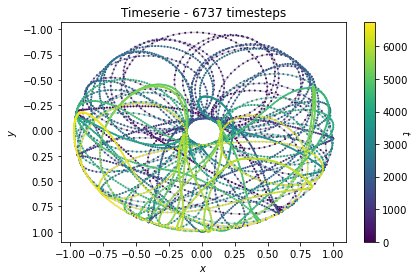

In [146]:
plot_sequence(dataset_p.sample_List[0], 4, 5)

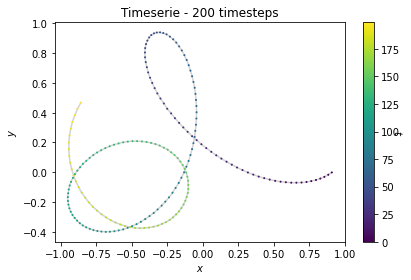

In [143]:
plot_sequence(dataset_p.sample_List[0][3000:3200],4,5)

which is circular overall. The more data we train the ESN on, the harder it is for the ESN to make the correct prediction.

One error with the current code is that it does not normalize the data to -1,1, but rather -0.5, 0.5. We will try a different idea of normalizing: instead of normalizing the x and the y, this time we normalize each axis.

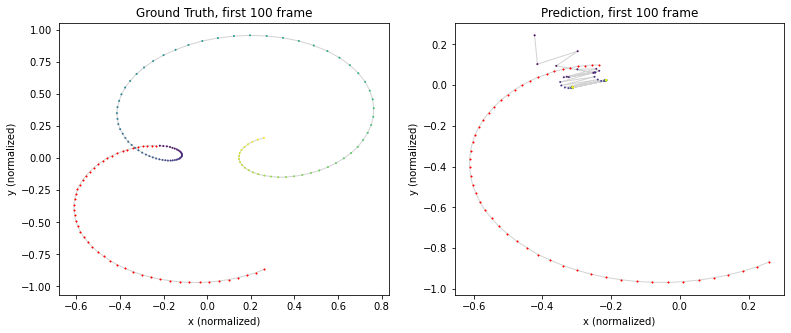

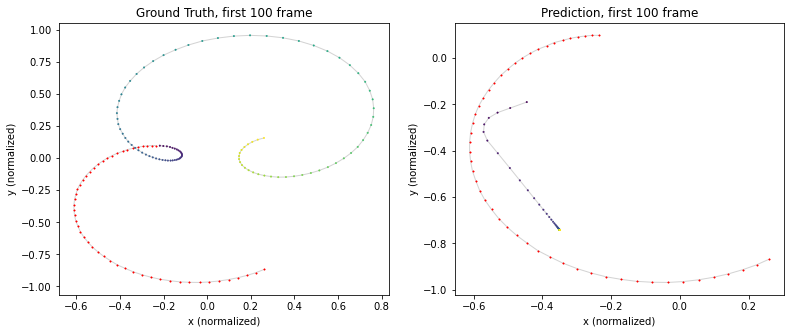

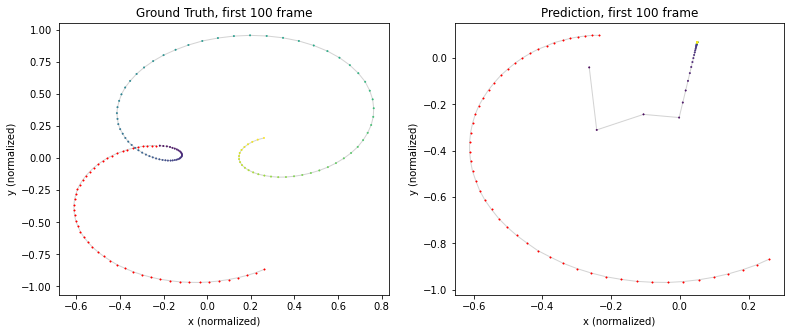

In [151]:
newmodel = ESNModel(units, 6, input_scaling, input_connectivity, input_bias=True, seed = seed, spectral_radius=spectral_radius, density=density, leak_rate=leak_rate, regularization=regularization)

newmodel.reset
state = newmodel.train_on_sequence(dataset_p, 0, train_length=100, forecast=1)
Xgen, Xgen_test, warming_inputs, states, warming_out, warming_states = newmodel.generate_on_sequence(dataset_p, 0, 50, 100, 300)
plot_comparison_with_warmup(Xgen,Xgen_test, warming_inputs,100,4,5)

newmodel.reset
state = newmodel.train_on_sequence(dataset_p, 10, train_length=100, forecast=3)
Xgen, Xgen_test, warming_inputs, states, warming_out, warming_states = newmodel.generate_on_sequence(dataset_p, 0, 50, 100, 300)
plot_comparison_with_warmup(Xgen,Xgen_test, warming_inputs,100,4,5)

newmodel.reset
state = newmodel.train_on_sequence(dataset_p, 10, train_length=100, forecast=5)
Xgen, Xgen_test, warming_inputs, states, warming_out, warming_states = newmodel.generate_on_sequence(dataset_p, 0, 50, 100, 300)
plot_comparison_with_warmup(Xgen,Xgen_test, warming_inputs,100,4,5)